In [207]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [208]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [209]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
bad_samples = ['NA19328']
df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [210]:
df.head()

,cell_line_id,sample,hapmap_DNA_ID,lab_sample,population,cell_line_id_1000g
0,HG04217,ITU5,no_hapmap,39_IN5_HG04217,ITU,HG04217
1,HG04216,ITU4,no_hapmap,38_IN4_HG04216,ITU,HG04216
2,HG03732,ITU3,no_hapmap,37_IN3_HG03732,ITU,HG03732
3,HG03729,ITU2,no_hapmap,36_IN2_HG03729,ITU,HG03729
4,HG03719,ITU1,no_hapmap,35_IN1_HG03719,ITU,HG03719


## How does IC sharing differ for the different genotypes?

In [211]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file, sep='\t')

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'Chromosome'].unique().tolist()
print(len(df.index))
df = df.loc[df.Chromosome.isin(hg38_chrs)]
print(len(df.index))

4549058
4549056


In [213]:
# remove unspliced
print(len(df.index))
df = df.loc[df.Coordinates != '-']
print(len(df.index))

4549056
4269257


In [214]:
df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)
df.head()

,Unnamed: 0,Chromosome,Strand,Coordinates,Name,genome,cell_line_id,ic_id
0,0,GL000195.1,-,86517-49092-48954-44923,ENSG00000276256_1,hg38,HG04217,GL000195.1_-_86517-49092-48954-44923
1,1,GL000195.1,-,86517-49119-48954-44923,ENSG00000276256_2,hg38,HG04217,GL000195.1_-_86517-49119-48954-44923
2,2,GL000195.1,-,86517-74180-74120-49119-48954-44923,ENSG00000303853_1,hg38,HG04217,GL000195.1_-_86517-74180-74120-49119-48954-44923
3,3,GL000195.1,-,86517-83958,ENSG00000303853_2,hg38,HG04217,GL000195.1_-_86517-83958
4,4,GL000195.1,-,86517-84116,ENSG00000303853_3,hg38,HG04217,GL000195.1_-_86517-84116


In [215]:
# what percentage of ics by cell line (personal haplotypes) 
# are found also by the reference genome?
big_df = pd.DataFrame()
for cl in df.cell_line_id.unique():
    temp = df.loc[df.cell_line_id==cl]
    temp = temp[['ic_id', 'genome']]
    temp['hg38'] = temp['hap1'] = temp['hap2'] = False
    temp.loc[temp.genome=='hg38', 'hg38'] = True
    temp.loc[temp.genome=='hap1', 'hap1'] = True
    temp.loc[temp.genome=='hap2', 'hap2'] = True

    temp = temp[['ic_id', 'hg38', 'hap1', 'hap2']].groupby('ic_id').max().reset_index()
    
    for h in ['hap1', 'hap2']:
        haplotypes = ['hg38', h]
        temp2 = temp[['ic_id'] + haplotypes]
        temp2 = temp2.loc[temp2[haplotypes].sum(axis=1)>=1]
        temp2 = temp2.groupby(haplotypes).nunique().reset_index()
        temp2.rename({'ic_id':'n_ic'}, axis=1, inplace=True)
        temp2['total'] = temp2.n_ic.sum()
        temp2['perc'] = (temp2.n_ic/temp2.total)*100
        temp2['haplotype'] = h
        temp2['cell_line_id'] = cl
        temp2.rename({h:'personal_haplotype'}, axis=1, inplace=True)
        big_df = pd.concat([big_df, temp2], axis=0)
#     # temp['personal'] = temp.hap1|temp.hap2
#     temp = temp.groupby(['hg38', 'hap1', 'hap2']).nunique().reset_index()
#     temp.rename({'ic_id':'n_ic'}, axis=1, inplace=True)
#     temp['total'] = temp['n_ic'].sum()
#     temp['perc'] = (temp.n_ic/temp.total)*100
    
#     # one haplotype at a time
#     temp2 = temp[['hg38', 'hap1', 'n_ic']]
#     temp2['total'] = temp2['n_ic'].sum()
#     temp2 = temp2.groupby(['hg38', 'hap1']).sum().reset_index()
#     temp2['haplotype'] = 'hap1'
#     temp2.rename({'hap1': 'personal_haplotype'}, axis=1, inplace=True)
#     temp2

#     # one haplotype at a time
#     temp3 = temp[['hg38', 'hap2', 'n_ic']]
#     temp3['total'] = temp3['n_ic'].sum()
#     temp3 = temp3.groupby(['hg38', 'hap2']).sum().reset_index()
#     temp3['haplotype'] = 'hap2'
#     temp3.rename({'hap2': 'personal_haplotype'}, axis=1, inplace=True)
#     temp3

#     temp2 = pd.concat([temp2, temp3], axis=0)
#     temp2['perc'] = (temp2['n_ic']/temp2['total'])*100
#     temp2
    
#     temp2['cell_line_id'] = cl
#     big_df = pd.concat([temp2, big_df], axis=0)

In [216]:
big_df.head()

,hg38,personal_haplotype,n_ic,total,perc,haplotype,cell_line_id
0,False,True,2165,55486,3.901885,hap1,HG04217
1,True,False,210,55486,0.378474,hap1,HG04217
2,True,True,53111,55486,95.719641,hap1,HG04217
0,False,True,2181,55502,3.929588,hap2,HG04217
1,True,False,196,55502,0.353140,hap2,HG04217


In [217]:
# distribution of F-T vs. F-T (hg38-personal haplotype ics)
big_df = big_df.loc[~((big_df.hg38==False)&(big_df.personal_haplotype==False))]
big_df['plot_cat'] = 'hg38 unique'
big_df.loc[(big_df.hg38==False)&(big_df.personal_haplotype==True), 'plot_cat'] = 'personal hap. unique'
big_df.loc[(big_df.hg38==True)&(big_df.personal_haplotype==True), 'plot_cat'] = 'shared'

In [218]:
big_df.head()

,hg38,personal_haplotype,n_ic,total,perc,haplotype,cell_line_id,plot_cat
0,False,True,2165,55486,3.901885,hap1,HG04217,personal hap. unique
1,True,False,210,55486,0.378474,hap1,HG04217,hg38 unique
2,True,True,53111,55486,95.719641,hap1,HG04217,shared
0,False,True,2181,55502,3.929588,hap2,HG04217,personal hap. unique
1,True,False,196,55502,0.353140,hap2,HG04217,hg38 unique


<AxesSubplot:xlabel='plot_cat', ylabel='perc'>

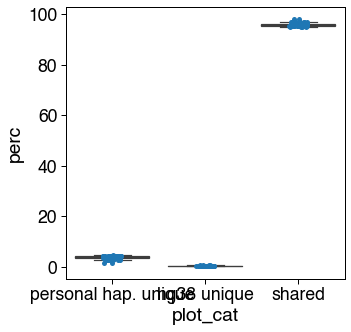

In [219]:
# sns.displot(big_df, x='perc', hue='plot_cat', kind='kde', common_norm=False)
# sns.boxplot(big_df, y='perc', hue='plot_cat', kind='kde', common_norm=False)

sns.boxplot(x='plot_cat', y='perc', data=big_df, showfliers=False)
sns.stripplot(x='plot_cat', y='perc', data=big_df, jitter=True)

In [220]:
med_shared = big_df.loc[big_df.plot_cat=='shared', 'perc'].median()
print(f'Median of {med_shared}% ICs (union of each hg38+personal hap. pair) are shared between each personal haplotype and hg38')

Median of 95.6528713520484% ICs (union of each hg38+personal hap. pair) are shared between each personal haplotype and hg38


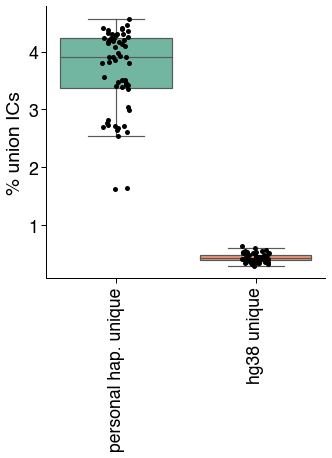

In [221]:
init_plot_settings()
temp = big_df.loc[big_df.plot_cat.isin(['personal hap. unique', 'hg38 unique'])]
sns.boxplot(x='plot_cat', y='perc', data=temp, showfliers=False, palette='Set2')
ax =sns.stripplot(x='plot_cat', y='perc', data=temp, jitter=True, color='k')
ax.set(xlabel='', ylabel='% union ICs')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [222]:
x = temp.loc[temp.plot_cat == 'personal hap. unique', 'perc'].tolist() # hypothesis is that this is greater
y = temp.loc[temp.plot_cat == 'hg38 unique', 'perc'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

Wilcoxon rank-sum test statistic: 9.287432920695053
Wilcoxon rank-sum test pval: 7.902712076699272e-21


In [223]:
len(big_df.index)

174

## How many ICs overall when we use personal haplotypes versus hg38?

In [224]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file, sep='\t')

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'Chromosome'].unique().tolist()
print(len(df.index))
df = df.loc[df.Chromosome.isin(hg38_chrs)]
print(len(df.index))

# remove unspliced
print(len(df.index))
df = df.loc[df.Coordinates != '-']
print(len(df.index))

df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)

df = df[['genome', 'ic_id', 'cell_line_id']].groupby(['genome', 'cell_line_id']).nunique().reset_index()
df.rename({'ic_id':'n_ic'}, axis=1, inplace=True)

4549058
4549056
4549056
4269257


In [225]:
df.loc[df.cell_line_id=='HG00621']

,genome,cell_line_id,n_ic
0,hap1,HG00621,64178
29,hap2,HG00621,64120
58,hg38,HG00621,62241


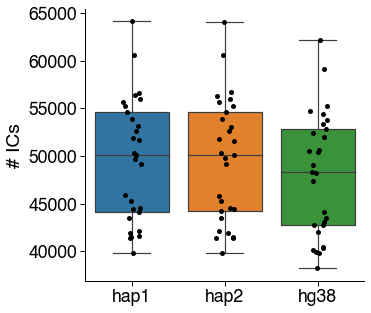

In [226]:
init_plot_settings()
sns.boxplot(x='genome', y='n_ic', data=df, showfliers=False)
ax =sns.stripplot(x='genome', y='n_ic', data=df, jitter=True, color='k')
ax.set(xlabel='', ylabel='# ICs')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [227]:
df[['genome', 'n_ic']].groupby('genome').median()

,n_ic
genome,
hap1,50099.0
hap2,50119.0
hg38,48367.0


In [228]:
for h in ['hap1', 'hap2']:
    x = df.loc[df.genome == h, 'n_ic'].tolist() # hypothesis is that this is greater
    y = df.loc[df.genome == 'hg38', 'n_ic'].tolist()

    stat, pval = st.ranksums(x, y, alternative='greater')
    print()
    print(h)
    print(x[:5])
    
    print(f'Wilcoxon rank-sum test statistic: {stat}')
    print(f'Wilcoxon rank-sum test pval: {pval}')


hap1
[64178, 52594, 44180, 51650, 49738]
Wilcoxon rank-sum test statistic: 1.0808151506109642
Wilcoxon rank-sum test pval: 0.13988967384108586

hap2
[64120, 52592, 44184, 51606, 49769]
Wilcoxon rank-sum test statistic: 1.0808151506109642
Wilcoxon rank-sum test pval: 0.13988967384108586


## How many ICs overall when we use personal haplotypes versus hg38? Are the differences more prominent based on different populations?

In [229]:
df = df.merge(meta_df[['cell_line_id_1000g', 'population']],
              how='left',
              left_on='cell_line_id',
              right_on='cell_line_id_1000g')
df.head()

,genome,cell_line_id,n_ic,cell_line_id_1000g,population
0,hap1,HG00621,64178,HG00621,HAC
1,hap1,HG01567,52594,HG01567,PEL
2,hap1,HG01928,44180,HG01928,PEL
3,hap1,HG01952,51650,HG01952,PEL
4,hap1,HG01975,49738,HG01975,PEL


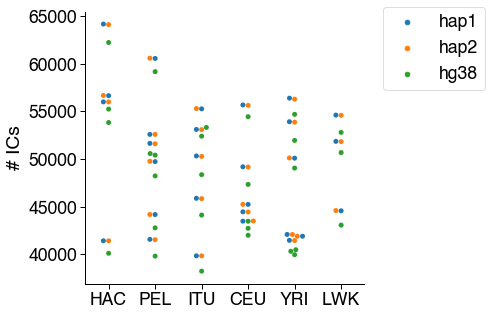

In [230]:
init_plot_settings()
ax = sns.swarmplot(x='population', hue='genome', y='n_ic', data=df)
# ax =sns.stripplot(x='population', hue='genome', y='n_ic', data=df, jitter=False, color='k')
ax.set(xlabel='', ylabel='# ICs')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.05))


## Do it with ratios instead

In [231]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file, sep='\t')

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'Chromosome'].unique().tolist()
print(len(df.index))
df = df.loc[df.Chromosome.isin(hg38_chrs)]
print(len(df.index))

# remove unspliced
print(len(df.index))
df = df.loc[df.Coordinates != '-']
print(len(df.index))

df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)

df = df[['genome', 'ic_id', 'cell_line_id']].groupby(['genome', 'cell_line_id']).nunique().reset_index()
df.rename({'ic_id':'n_ic'}, axis=1, inplace=True)

4549058
4549056
4549056
4269257


In [232]:
df = df.pivot(index='cell_line_id', columns='genome', values='n_ic').reset_index()
df['hap1_ratio'] = df['hap1']/df['hg38']
df['hap2_ratio'] = df['hap2']/df['hg38']

In [233]:
temp = df[['cell_line_id', 'hap1_ratio', 'hap2_ratio']]
temp = temp.melt(id_vars='cell_line_id')
temp.rename({'value':'ratio'}, axis=1, inplace=True)

In [234]:
temp.head()

,cell_line_id,genome,ratio
0,HG00621,hap1_ratio,1.031121
1,HG01567,hap1_ratio,1.039839
2,HG01928,hap1_ratio,1.032605
3,HG01952,hap1_ratio,1.024497
4,HG01975,hap1_ratio,1.031181


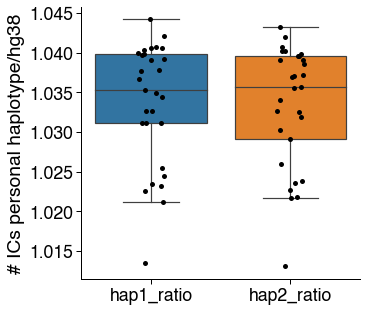

In [235]:
init_plot_settings()
sns.boxplot(x='genome', y='ratio', data=temp, showfliers=False)
ax =sns.stripplot(x='genome', y='ratio', data=temp, jitter=True, color='k')
ax.set(xlabel='', ylabel='# ICs personal haplotype/hg38')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

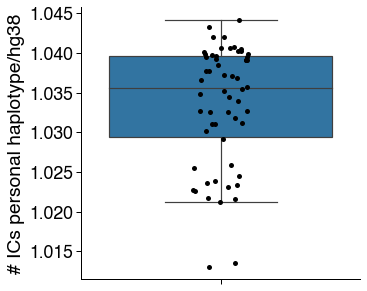

In [236]:
init_plot_settings()
sns.boxplot(y='ratio', data=temp, showfliers=False)
ax =sns.stripplot(y='ratio', data=temp, jitter=True, color='k')
ax.set(xlabel='', ylabel='# ICs personal haplotype/hg38')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [237]:
med = temp.ratio.median()
print(f'Median ratio of personal genome # ics / hg38 # ics: {med}')

Median ratio of personal genome # ics / hg38 # ics: 1.0355949619475164


## Do we get more NNC (novel splice site) when we look at the personal haploytpes versus the hg38?

In [241]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['cl_summary'],od)
df = pd.read_csv(file, sep='\t')
df.head()

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'chrom'].unique().tolist()
print(len(df.index))
df = df.loc[df.chrom.isin(hg38_chrs)]
print(len(df.index))

# remove unspliced
print(len(df.index))
df = df.loc[df.exons != 1]
print(len(df.index))

4592884
4592882
4592882
4307119


In [242]:
df.head()

,Unnamed: 0,isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,...,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,genome,cell_line_id
0,0,ENST00000400754.4,GL000194.1,-,1599,4,full-splice_match,ENSG00000274847.1,ENST00000400754.4,1599.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
1,1,ENST00000613230.1,GL000194.1,-,2179,3,full-splice_match,ENSG00000277400.1,ENST00000613230.1,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
2,2,ESPRESSO:GL000194.1:0:0,GL000194.1,-,713,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
3,3,ESPRESSO:GL000194.1:0:1,GL000194.1,-,462,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
4,4,ESPRESSO:GL000194.1:0:2,GL000194.1,-,456,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217


In [243]:
# count the number of isoforms per structural cateogry in each cell line / genome
df = df[['genome', 'cell_line_id', 'structural_category', 'isoform']]
df = df.reset_index()df = df.groupby(['genome', 'cell_line_id', 'structural_category']).nunique().rename({'isoform':'n_t'}, axis=1)

In [245]:
df['total_n_t'] = df.groupby(['genome', 'cell_line_id'])['n_t'].transform('sum')
df['perc'] = (df['n_t']/df['total_n_t'])*100

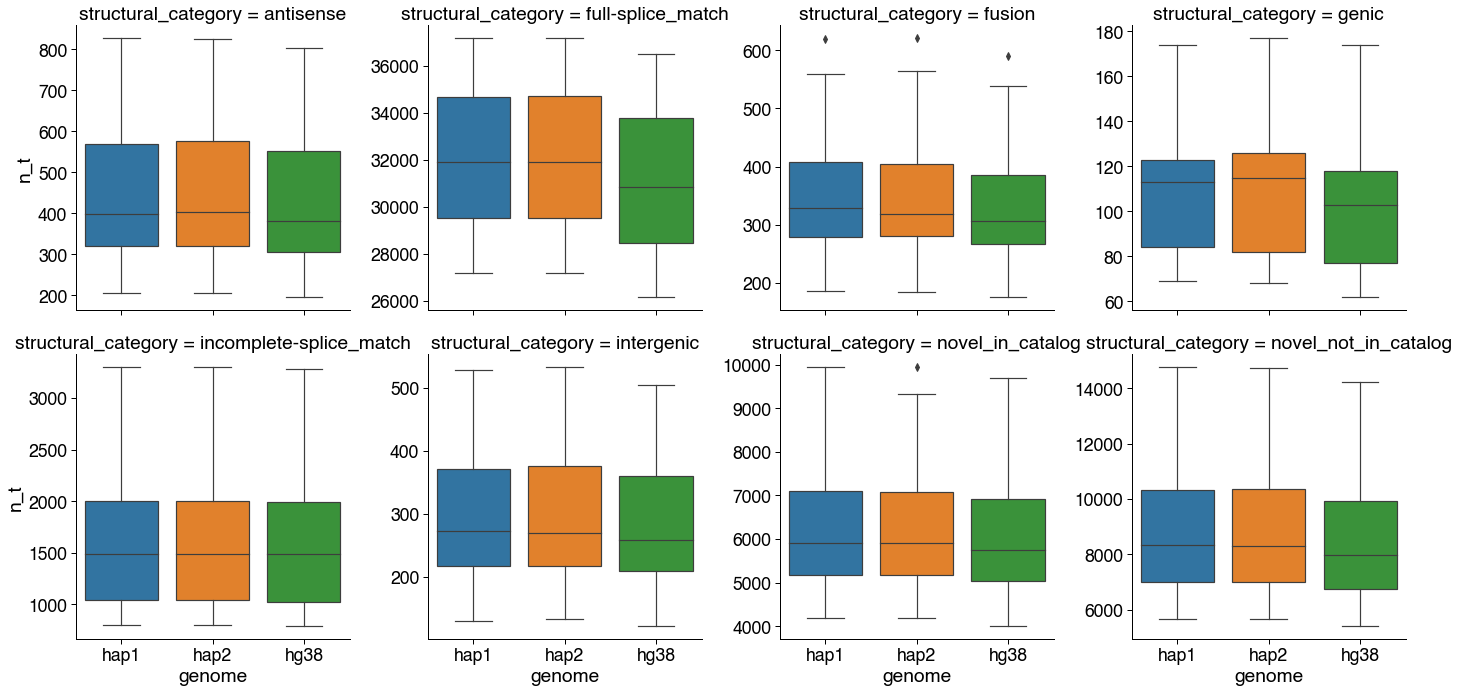

In [246]:
sns.catplot(
    data=df, x='genome', y='n_t',
    col='structural_category', kind='box',
    col_wrap=4, sharey=False
)

## What about number of transcripts w/ all splice sites canonical

In [247]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['cl_summary'],od)
df = pd.read_csv(file, sep='\t')
df.head()

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'chrom'].unique().tolist()
print(len(df.index))
df = df.loc[df.chrom.isin(hg38_chrs)]
print(len(df.index))

# remove unspliced
print(len(df.index))
df = df.loc[df.exons != 1]
print(len(df.index))

4592884
4592882
4592882
4307119


In [248]:
df.all_canonical.unique()

array(['canonical', 'non_canonical'], dtype=object)

In [249]:
df.head()

,Unnamed: 0,isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,...,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,genome,cell_line_id
0,0,ENST00000400754.4,GL000194.1,-,1599,4,full-splice_match,ENSG00000274847.1,ENST00000400754.4,1599.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
1,1,ENST00000613230.1,GL000194.1,-,2179,3,full-splice_match,ENSG00000277400.1,ENST00000613230.1,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
2,2,ESPRESSO:GL000194.1:0:0,GL000194.1,-,713,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
3,3,ESPRESSO:GL000194.1:0:1,GL000194.1,-,462,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
4,4,ESPRESSO:GL000194.1:0:2,GL000194.1,-,456,3,novel_not_in_catalog,ENSG00000277400.1,novel,2179.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217


In [252]:
# count the number of isoforms per structural cateogry in each cell line / genome
df = df[['genome', 'cell_line_id', 'all_canonical', 'isoform']]
df = df.groupby(['genome', 'cell_line_id', 'all_canonical']).nunique().rename({'isoform': 'n_t'}, axis=1).reset_index()

In [254]:
# get % non canonical
df['total_n_t'] = df.groupby(['genome', 'cell_line_id'])['n_t'].transform('sum')
df['perc'] = (df['n_t']/df['total_n_t'])*100
df.head()

,genome,cell_line_id,all_canonical,n_t,total_n_t,perc
0,hap1,HG00621,canonical,64536,64674,99.786622
1,hap1,HG00621,non_canonical,138,64674,0.213378
2,hap1,HG01567,canonical,52928,53052,99.766267
3,hap1,HG01567,non_canonical,124,53052,0.233733
4,hap1,HG01928,canonical,44516,44616,99.775865


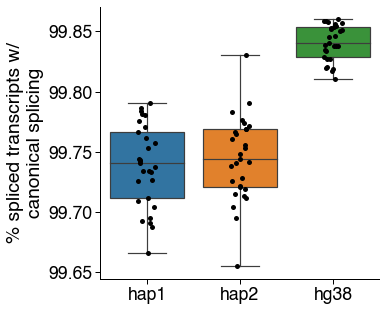

In [256]:
# just noncanonical
df = df.loc[df.all_canonical=='canonical']
init_plot_settings()
sns.boxplot(x='genome', y='perc', data=df, showfliers=False)
ax =sns.stripplot(x='genome', y='perc', data=df, jitter=True, color='k')
ax.set(xlabel='', ylabel='% spliced transcripts w/\ncanonical splicing')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## What about just raw number / percentage of novel splice sites

In [262]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file, sep='\t')

df['sj_id'] = df['chrom'].astype(str)+'_'+\
              df['strand'].astype(str)+'_'+\
              df['genomic_start_coord'].astype(str)+'_'+\
              df['genomic_end_coord'].astype(str)

,Unnamed: 0,isoform,chrom,strand,junction_number,genomic_start_coord,genomic_end_coord,transcript_coord,junction_category,start_site_category,...,canonical,RTS_junction,indel_near_junct,phyloP_start,phyloP_end,sample_with_cov,total_coverage_unique,total_coverage_multi,genome,cell_line_id
0,0,ENST00000613230.1,GL000194.1,-,junction_1,55677,112791,?????,known,known,...,canonical,False,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
1,1,ENST00000613230.1,GL000194.1,-,junction_2,112851,114985,?????,known,known,...,canonical,False,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
2,2,ENST00000400754.4,GL000194.1,-,junction_1,54833,55445,?????,known,known,...,canonical,False,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
3,3,ENST00000400754.4,GL000194.1,-,junction_2,55677,112791,?????,known,known,...,canonical,False,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217
4,4,ENST00000400754.4,GL000194.1,-,junction_3,112851,114985,?????,known,known,...,canonical,False,NaN,NaN,NaN,NaN,NaN,NaN,hg38,HG04217


In [263]:
df['sj_id'] = df['chrom'].astype(str)+'_'+\
              df['strand'].astype(str)+'_'+\
              df['genomic_start_coord'].astype(str)+'_'+\
              df['genomic_end_coord'].astype(str)

In [264]:
df = df[['sj_id', 'canonical', 'genome', 'cell_line_id']]
df = df.groupby(['canonical', 'genome', 'cell_line_id']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

In [266]:
# get % non canonical
df['total_n_sj'] = df.groupby(['genome', 'cell_line_id'])['n_sj'].transform('sum')
df['perc'] = (df['n_sj']/df['total_n_sj'])*100
df.head()

,canonical,genome,cell_line_id,n_sj,total_n_sj,perc
0,canonical,hap1,HG00621,109149,109247,99.910295
1,canonical,hap1,HG01567,100244,100334,99.910300
2,canonical,hap1,HG01928,85082,85157,99.911927
3,canonical,hap1,HG01952,94170,94250,99.915119
4,canonical,hap1,HG01975,91621,91709,99.904044


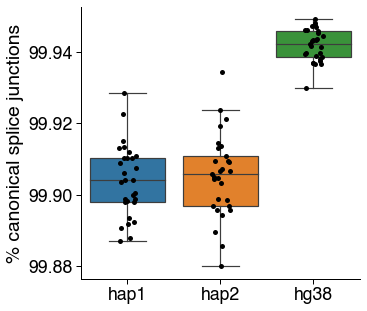

In [267]:
# just noncanonical
df = df.loc[df.canonical=='canonical']
init_plot_settings()
sns.boxplot(x='genome', y='perc', data=df, showfliers=False)
ax =sns.stripplot(x='genome', y='perc', data=df, jitter=True, color='k')
ax.set(xlabel='', ylabel='% canonical splice junctions')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Are there any splice junctions that go from having canonical to non canonical ? Sankey plots?

In [285]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file, sep='\t')

df['sj_id'] = df['chrom'].astype(str)+'_'+\
              df['strand'].astype(str)+'_'+\
              df['genomic_start_coord'].astype(str)+'_'+\
              df['genomic_end_coord'].astype(str)

In [286]:
df = df[['canonical', 'genome', 'cell_line_id', 'sj_id']]

hg38 = df.loc[df.genome=='hg38'].copy(deep=True)
hg38 = hg38[['canonical', 'genome', 'sj_id']].drop_duplicates()
personal = df.loc[df.genome!='hg38'].copy(deep=True)

In [287]:
hg38.head()

,canonical,genome,sj_id
0,canonical,hg38,GL000194.1_-_55677_112791
1,canonical,hg38,GL000194.1_-_112851_114985
2,canonical,hg38,GL000194.1_-_54833_55445
5,canonical,hg38,GL000194.1_-_53863_54677
9,canonical,hg38,GL000194.1_-_53893_54677


In [288]:
assert len(hg38.loc[hg38.sj_id.duplicated(keep=False)].sort_values(by='sj_id')) ==0

In [289]:
hg38['canonical_in_personal_haplotype'] = hg38.sj_id.isin(personal.loc[personal.canonical=='canonical'].sj_id.tolist())

In [292]:
hg38['canonical_in_personal_haplotype'] = hg38['canonical_in_personal_haplotype'].map({True:'canonical', False: 'non_canonical'})

In [296]:
hg38.loc[hg38.canonical!=hg38.canonical_in_personal_haplotype]
hg38 = hg38[['canonical', 'canonical_in_personal_haplotype', 'sj_id']]
df= hg38.groupby(['canonical', 'canonical_in_personal_haplotype']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

[Text(0, 0.5, '# SJs'), Text(0.5, 0, '')]

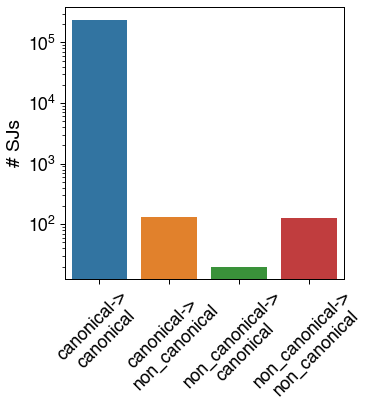

In [303]:
df['cat'] = df['canonical']+'->\n'+df['canonical_in_personal_haplotype']
ax = sns.barplot(df, x='cat', y='n_sj')
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set(ylabel='# SJs', xlabel='')


## Why are we detecting a lot more transcripts in the personal genomes versus the others?